## PS5 

#### MACS 30100
Author: Jiang Wang

In [1]:
#Import the packages
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import seaborn as sb
sb.set_style('whitegrid')
from pylab import rcParams
#Import Scikit-learn
import sklearn
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split #use to split train and test data
from sklearn.model_selection import LeaveOneOut, KFold #import the cross validation methods
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error
#Import modules used in Part2
import statsmodels.api as sm
from scipy.interpolate import LSQUnivariateSpline
#Graphing
%matplotlib inline

C:\Users\jiangwang-admin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\jiangwang-admin\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Part1: Multinomial logistic regression and cross validation

In [2]:
src = pd.read_csv('strongdrink.txt') #import the source
df1 = src[['cultivar','alco','malic','tot_phen','color_int']] #slice the data for problem (a)
df1.head()

,cultivar,alco,malic,tot_phen,color_int
0,1,14.23,1.71,2.80,5.64
1,1,13.20,1.78,2.65,4.38
2,1,13.16,2.36,2.80,5.68
3,1,14.37,1.95,3.85,7.80
4,1,13.24,2.59,2.80,4.32


In [3]:
df1.isnull().sum()

cultivar     0
alco         0
malic        0
tot_phen     0
color_int    0
dtype: int64

In [4]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176 entries, 0 to 175
Data columns (total 5 columns):
cultivar     176 non-null int64
alco         176 non-null float64
malic        176 non-null float64
tot_phen     176 non-null float64
color_int    176 non-null float64
dtypes: float64(4), int64(1)
memory usage: 7.0 KB


##### (a) M-logit regression

In [5]:
#Set the variables
X = df1[['alco','malic','tot_phen','color_int']]
y = df1[['cultivar']]
#split the data into train set and test set
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size = 0.25,
        random_state=20)
#Multi-logit
MultLogReg = LogisticRegression(multi_class='multinomial',
                                solver='newton-cg')
resultA1 = MultLogReg.fit(X_train, y_train.values.ravel())

In [6]:
#Report the coefficients
for x in range(2):
    print(f'The estimated coefficients for j={x+1}:')
    print('b0 =', resultA1.intercept_[x])
    for y in range(4):
        print(f'b{y+1} =',resultA1.coef_[x][y])
    print('')

The estimated coefficients for j=1:
b0 = -24.0109894515
b1 = 1.7004033763
b2 = -0.265605226518
b3 = 1.2238937289
b4 = 0.0227563746875

The estimated coefficients for j=2:
b0 = 22.8024461982
b1 = -1.46804431964
b2 = -0.333053122096
b3 = 0.664011854001
b4 = -0.922712234869



In [7]:
y_pred = MultLogReg.predict(X_test)
confusion_matrix = confusion_matrix(y_test, y_pred)
confusion_matrix

array([[13,  0,  0],
       [ 2, 19,  0],
       [ 0,  0, 10]], dtype=int64)

In [8]:
#Print the error rate
print(classification_report(y_test, y_pred))
print('The error rate of class 1 (j=1) is {}'.format(1-0.87))
print('The error rate of class 2 (j=2) is {}'.format(1-1))
print('The error rate of class 3 (j=3) is {}'.format(1-1))
#Get the MSE of this model, note the following two methods yield the same result
#MSE_vs = ((y_test.values.ravel() - y_pred) ** 2).sum() / y_pred.shape[0]
#print('Validation set MSE = ', MSE_vs)
print('Set Average MSE = ', mean_squared_error(y_test, y_pred))

             precision    recall  f1-score   support

          1       0.87      1.00      0.93        13
          2       1.00      0.90      0.95        21
          3       1.00      1.00      1.00        10

avg / total       0.96      0.95      0.96        44

The error rate of class 1 (j=1) is 0.13
The error rate of class 2 (j=2) is 0
The error rate of class 3 (j=3) is 0
Set Average MSE =  0.0454545454545


In [9]:
df1.cultivar.value_counts()

2    71
1    59
3    46
Name: cultivar, dtype: int64

1a) Answer: 

The model is best at predicting the category j=2 and j=3, each with an error rate of 0.0. 

Checking the f-score (balancing precision and recall), we can see j=3 is the most accurately predicted category, however it has the least observations in this sample (n=46). So the category the model predicts most accurately is not the one with the most observations.

##### (b) Leave-one-out cross validation (LOOCV)

In [10]:
#Leave-one-out
Xvars = df1[['alco','malic','tot_phen','color_int']].values
yvals = df1[['cultivar']].values
#Adjust the shape of yvals
yvals.shape = (yvals.shape[0],) #It seems there is some differences between shape (x,1) and (x,) when broadcasting
N_loo = Xvars.shape[0]
loo = LeaveOneOut()
loo.get_n_splits(Xvars)
MSE = pd.DataFrame({'index': np.zeros(N_loo), 
                    'error': np.zeros(N_loo), 
                    'y_pred': np.zeros(N_loo),
                    'y_test': np.zeros(N_loo)})
#Begin to estimate MSE
for train_index, test_index in loo.split(Xvars):
    X_train, X_test = Xvars[train_index], Xvars[test_index]
    y_train, y_test = yvals[train_index], yvals[test_index]
    LogReg = LogisticRegression(multi_class='multinomial',solver='newton-cg')
    LogReg.fit(X_train, y_train)
    y_pred = LogReg.predict(X_test)
    MSE['index'][test_index] = test_index
    MSE['error'][test_index] = (((y_test - y_pred) ** 2) != 0).astype(int)
    MSE['y_pred'][test_index] = y_pred
    MSE['y_test'][test_index] = y_test
#Compute the errors
error_1 = MSE[MSE['y_pred'] == 1]['error'].mean()
error_2 = MSE[MSE['y_pred'] == 2]['error'].mean()
error_3 = MSE[MSE['y_pred'] == 3]['error'].mean()
MSE_All = MSE['error'].mean()

In [11]:
print(classification_report(MSE['y_test'], MSE['y_pred'], digits = 3))
print('The error rate for category j=1 is', round(error_1,3),
      ', standard error is', round(MSE[MSE['y_pred'] == 1]['error'].std(),3))
print('The error rate for category j=2 is', round(error_2,3), 
      ', standard error is', round(MSE[MSE['y_pred'] == 2]['error'].std(),3))
print('The error rate for category j=3 is', round(error_3,3), 
      ', standard error is', round(MSE[MSE['y_pred'] == 3]['error'].std(),3))
print('The average MSE (for all catogeries) is', round(MSE_All,3),
      ', standard error is', round(MSE['error'].std(),3))

             precision    recall  f1-score   support

        1.0      0.902     0.932     0.917        59
        2.0      0.914     0.901     0.908        71
        3.0      0.956     0.935     0.945        46

avg / total      0.921     0.920     0.921       176

The error rate for category j=1 is 0.098 , standard error is 0.3
The error rate for category j=2 is 0.086 , standard error is 0.282
The error rate for category j=3 is 0.044 , standard error is 0.208
The average MSE (for all catogeries) is 0.08 , standard error is 0.271


1b) Answer: Compared to part(a), the error rate is smaller for category j=1, but bigger for categories j=2 and j=3. The average MSE is larger than that in part(a).

##### (c) K-fold

In [12]:
k=4
kf = KFold(n_splits=k, random_state=10, shuffle=True)
kf.get_n_splits(Xvars)
k_ind = int(0)
error_1 = np.zeros(k)
error_2 = np.zeros(k)
error_3 = np.zeros(k)
error_all = np.zeros(k)

for train_index, test_index in kf.split(Xvars):
    print('k index=', k_ind)
    X_train, X_test = Xvars[train_index], Xvars[test_index]
    y_train, y_test = yvals[train_index], yvals[test_index]
    LogReg = LogisticRegression(multi_class='multinomial',solver='newton-cg')
    LogReg.fit(X_train, y_train)
    y_pred = LogReg.predict(X_test)
    MSE = pd.DataFrame({'error': (((y_test - y_pred) ** 2) != 0).astype(int), 
                    'y_pred': y_pred})
    error_1[k_ind] = MSE[MSE['y_pred'] == 1]['error'].mean()
    error_2[k_ind] = MSE[MSE['y_pred'] == 2]['error'].mean()
    error_3[k_ind] = MSE[MSE['y_pred'] == 3]['error'].mean()
    error_all[k_ind] = MSE['error'].mean()
    print('MSE for test set {} is {}'.format(k_ind, MSE['error'].mean()))
    k_ind += 1

k index= 0
MSE for test set 0 is 0.1590909090909091
k index= 1
MSE for test set 1 is 0.11363636363636363
k index= 2
MSE for test set 2 is 0.045454545454545456
k index= 3
MSE for test set 3 is 0.045454545454545456


In [13]:
print('1C:')
print('The average error rate (category j=1) is', round(error_1.mean(),5),
     '\nThe standard error of this estimate is', round(error_1.std(),5))
print('\nThe average error rate (category j=2) is', round(error_2.mean(),5),
     '\nThe standard error of this estimate is', round(error_2.std(),5))
print('\nThe average error rate (category j=3) is', round(error_3.mean(),5),
     '\nThe standard error of this estimate is', round(error_3.std(),5))
print('\nThe average MSE (for all categories) is', round(error_all.mean(),5),
     '\nThe standard error of this estimate is', round(error_all.std(),5))

1C:
The average error rate (category j=1) is 0.11857 
The standard error of this estimate is 0.10957

The average error rate (category j=2) is 0.09375 
The standard error of this estimate is 0.12885

The average error rate (category j=3) is 0.05556 
The standard error of this estimate is 0.09623

The average MSE (for all categories) is 0.09091 
The standard error of this estimate is 0.04821


1C) Answer: The error rates of K-fold is very close to those in LOOCV. 

The average MSE and error rate in the category j=1 in K-fold (part c) and LOOCV (part a) are lower than those in part a.

The error rate in the categories j=2 and j=3 in K-fold (part c) and LOOCV (part a) are higher than those in part a.

### Part2: Splines and Interpolation

In [14]:
cool = pd.read_csv('CoolIndex.txt', sep=',', header=None)
cool.columns = ['age','index']
cool.head()

,age,index
0,11.0,10.981602
1,11.0,11.364925
2,11.0,10.190227
3,11.0,9.903725
4,11.0,8.997918


##### (a) scatterplot

Text(0,0.5,'Coolness Index Value')

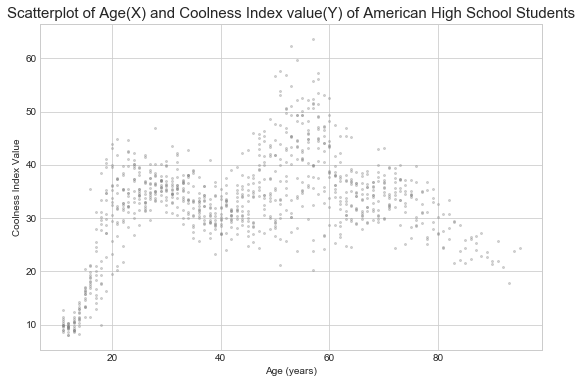

In [15]:
fig1 = plt.figure(figsize = (9,6))
plt.scatter(cool['age'], cool['index'], s = 4, c = 'grey', alpha = 0.3)
plt.title('Scatterplot of Age(X) and Coolness Index value(Y) of American High School Students', fontsize = 15)
plt.xlabel(r'Age (years)')
plt.ylabel(r'Coolness Index Value')

##### (b) Step functions

In [16]:
age = cool['age']
age_bin1 = ((age >= 11) & (age < 22)).astype(int)
age_bin2 = ((age >= 22) & (age < 40)).astype(int)
age_bin3 = ((age >= 40) & (age < 59)).astype(int)
age_bin4 = ((age >= 59) & (age < 77)).astype(int)
age_bin5 = ((age >= 77) & (age <= 95)).astype(int)
X_step = pd.DataFrame(dict(age_11_22=age_bin1, age_22_40=age_bin2,
                           age_40_59=age_bin3, age_59_77=age_bin4,
                           age_77_95=age_bin5))
X_step.describe()

,age_11_22,age_22_40,age_40_59,age_59_77,age_77_95
count,956.000000,956.000000,956.000000,956.000000,956.000000
mean,0.162134,0.276151,0.285565,0.217573,0.058577
std,0.368767,0.447326,0.451919,0.412812,0.234955
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [17]:
regB1 = sm.OLS(endog=cool['index'], exog=X_step, missing='drop')
regB1_results = regB1.fit()
print(regB1_results.summary())

                            OLS Regression Results                            
Dep. Variable:                  index   R-squared:                       0.429
Model:                            OLS   Adj. R-squared:                  0.427
Method:                 Least Squares   F-statistic:                     178.7
Date:                Mon, 19 Feb 2018   Prob (F-statistic):          3.73e-114
Time:                        09:00:56   Log-Likelihood:                -3214.5
No. Observations:                 956   AIC:                             6439.
Df Residuals:                     951   BIC:                             6463.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age_11_22     20.1025      0.562     35.746      0.0

In [18]:
age_step = np.array([11, 22, 40, 59, 77, 95])
cool_step = np.append(regB1_results.params[0], regB1_results.params)

Text(0,0.5,'Coolness Index Value')

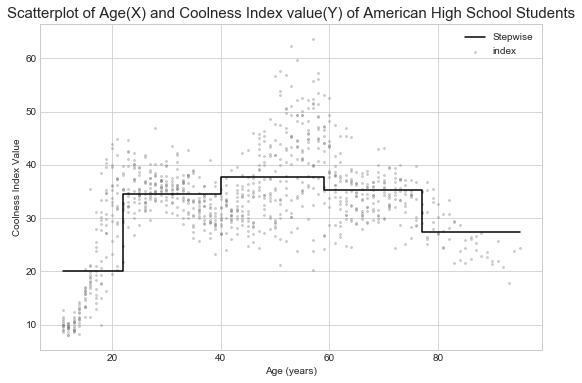

In [19]:
fig2 = plt.figure(figsize = (9,6))
plt.scatter(cool['age'], cool['index'], s = 4, c = 'grey', alpha = 0.3)
plt.step(age_step, cool_step, 'k-', label='Stepwise')
plt.legend(loc='best')
plt.title('Scatterplot of Age(X) and Coolness Index value(Y) of American High School Students', fontsize = 15)
plt.xlabel(r'Age (years)')
plt.ylabel(r'Coolness Index Value')

In [20]:
print('2B:The estimated step function values for each bin are:')
[print('bin{} ='.format(x+1),regB1_results.params[x]) for x in range(5)]
print('\nThe predicted coolness index value of 73-year old is', regB1_results.params[3])

2B:The estimated step function values for each bin are:
bin1 = 20.1024572521
bin2 = 34.4757880776
bin3 = 37.6351054924
bin4 = 35.2254000402
bin5 = 27.2963782443

The predicted coolness index value of 73-year old is 35.2254000402


##### (c) Linear Spline

In [21]:
knots = [22, 40, 59, 77]
spl_linear = LSQUnivariateSpline(cool['age'].values, cool['index'].values, knots, k=1)
age_vec = np.linspace(age.values.min(), age.values.max(), 1000)

Text(0,0.5,'Coolness Index Value')

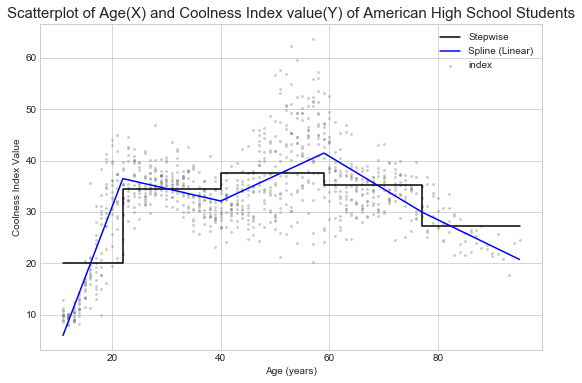

In [22]:
fig3 = plt.figure(figsize = (9,6))
plt.scatter(cool['age'], cool['index'], s = 4, c = 'grey', alpha = 0.3)
plt.step(age_step, cool_step, 'k-', label='Stepwise')
plt.plot(age_vec, spl_linear(age_vec), 'b-', label='Spline (Linear)')
plt.legend(loc='best')
plt.title('Scatterplot of Age(X) and Coolness Index value(Y) of American High School Students', fontsize = 15)
plt.xlabel(r'Age (years)')
plt.ylabel(r'Coolness Index Value')

In [23]:
print('2C:The predicted coolness index value of 73-year old is', spl_linear(73))

2C:The predicted coolness index value of 73-year old is 32.536832389143306


##### (d) Cubic Spline

In [24]:
spl_cubic = LSQUnivariateSpline(cool['age'].values, cool['index'].values, knots, k=3)

Text(0,0.5,'Coolness Index Value')

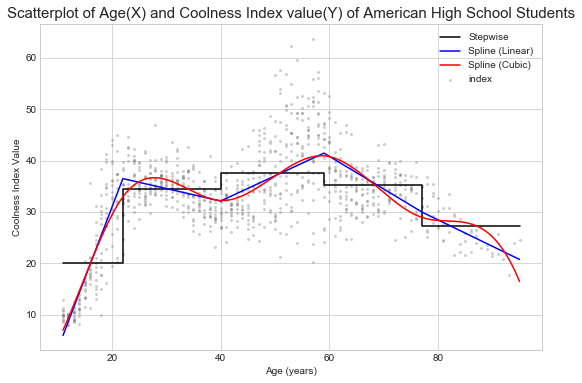

In [25]:
fig4 = plt.figure(figsize = (9,6))
plt.scatter(cool['age'], cool['index'], s = 4, c = 'grey', alpha = 0.3)
plt.step(age_step, cool_step, 'k-', label='Stepwise')
plt.plot(age_vec, spl_linear(age_vec), 'b-', label='Spline (Linear)')
plt.plot(age_vec, spl_cubic(age_vec), 'r-', label='Spline (Cubic)')
plt.legend(loc='best')
plt.title('Scatterplot of Age(X) and Coolness Index value(Y) of American High School Students', fontsize = 15)
plt.xlabel(r'Age (years)')
plt.ylabel(r'Coolness Index Value')

In [26]:
print('2D:The predicted coolness index value of 73-year old is', spl_cubic(73))

2D:The predicted coolness index value of 73-year old is 31.262429389257864
